# Modeling
***

## Installing Packages and Libraries

In [285]:
# Uncomment to upgrade packages
#!pip3 install pandas --user --upgrade --quiet
#!pip3 install scipy --user --upgrade --quiet
#!pip3 install numpy --user --upgrade --quiet
#!pip3 install statsmodels --user --upgrade --quiet
#!pip3 install seaborn --user --upgrade --quiet

In [48]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [49]:
# extra imports
from pandas import read_csv
from scipy.stats import boxcox, shapiro, chi2, chi2_contingency
from matplotlib import patches
import seaborn as sns

In [50]:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
# from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.metrics import make_scorer
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import make_scorer
from sklearn import svm

from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
seed = 223344

In [51]:
np.random.seed(666)

In [52]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3));
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False);

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Calculate and print the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    # Calculate the F1 score for each class and the overall weighted average
    f1_scores = f1_score(y_test, y_pred, average=None)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the F1 scores for each class
    print("F1 Scores (Per Class):")
    for idx, f1 in enumerate(f1_scores):
        print(f"Class {idx}: {f1}")

    # Print the overall weighted F1 score
    print("Weighted F1 Score:", weighted_f1)

***
# SECTION 1: Reading the Dataset `bank_marketing_new.csv`

In this first part we are going to load the dataset and get a first overview of the available data.

In [53]:
bank_marketing = read_csv("./bank_marketing_new.csv", header=0, delimiter=',')

#bank_marketing = bank_marketing.drop(columns=['job','campaign','previous'])
#bank_marketing = bank_marketing.rename(columns={'job2': 'job'})
bank_marketing = bank_marketing.drop(columns=['job2','log_campaign','log_previous'])
    

bank_marketing.head(20)


,age,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,y,job
0,28,single,2,no,2528,yes,no,cellular,18,may,8,0,no,others
1,35,single,3,no,51,no,no,cellular,18,aug,5,0,no,business
2,48,single,2,no,469,no,yes,cellular,9,jul,1,0,no,others
3,51,married,3,no,1315,no,no,telephone,5,jun,2,0,no,others
4,36,single,3,no,688,no,no,cellular,2,jun,1,1,no,business
5,41,married,3,no,23,no,no,cellular,22,aug,2,0,no,business
6,30,single,2,no,248,yes,no,cellular,13,may,1,0,no,others
7,32,divorced,2,no,8,yes,no,cellular,16,jul,1,0,no,others
8,41,married,1,no,574,yes,no,Unknown,14,may,2,0,no,others
9,47,married,1,no,1056,no,no,telephone,29,aug,2,0,no,others


As we can see, the dataset has **4019** observations and **21** columns (variables). Our target value is the `Status` of the patient and it can be binary (Dead or Alive).

In [54]:
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43611 entries, 0 to 43610
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        43611 non-null  int64 
 1   marital    43611 non-null  object
 2   education  43611 non-null  int64 
 3   default    43611 non-null  object
 4   balance    43611 non-null  int64 
 5   housing    43611 non-null  object
 6   loan       43611 non-null  object
 7   contact    43611 non-null  object
 8   day        43611 non-null  int64 
 9   month      43611 non-null  object
 10  campaign   43611 non-null  int64 
 11  previous   43611 non-null  int64 
 12  y          43611 non-null  object
 13  job        43611 non-null  object
dtypes: int64(6), object(8)
memory usage: 4.7+ MB


Below we can see the first 5 rows of the dataset in order to have a brief overview of the available data.

In [55]:
bank_marketing.describe(include='all')

,age,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,y,job
count,43611.000000,43611,43611.000000,43611,43611.000000,43611,43611,43611,43611.000000,43611,43611.000000,43611.000000,43611,43611
unique,NaN,3,NaN,2,NaN,2,2,3,NaN,12,NaN,NaN,2,2
top,NaN,married,NaN,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,no,others
freq,NaN,26230,NaN,42837,NaN,24288,36667,28344,NaN,13481,NaN,NaN,38400,27995
mean,40.943134,NaN,2.147371,NaN,1351.438697,NaN,NaN,NaN,15.624086,NaN,2.333586,0.528857,NaN,NaN
std,10.645034,NaN,0.664455,NaN,2828.449413,NaN,NaN,NaN,8.268368,NaN,1.672847,1.499892,NaN,NaN
min,18.000000,NaN,1.000000,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,2.000000,NaN,75.000000,NaN,NaN,NaN,8.000000,NaN,1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,2.000000,NaN,453.000000,NaN,NaN,NaN,16.000000,NaN,2.000000,0.000000,NaN,NaN
75%,48.000000,NaN,3.000000,NaN,1433.000000,NaN,NaN,NaN,21.000000,NaN,3.000000,0.000000,NaN,NaN


# SECTION 2: Categorical vars preprocessing

In [56]:
#Boolean yes,no to 1,0

yes_no_mapping = {'yes':1, 'no': 0}
bank_marketing['default'] = bank_marketing['default'].map(yes_no_mapping)
bank_marketing['housing'] = bank_marketing['housing'].map(yes_no_mapping)
bank_marketing['loan'] = bank_marketing['loan'].map(yes_no_mapping)
bank_marketing['y'] = bank_marketing['y'].map(yes_no_mapping)

yes_no_mapping = {'business':1, 'others': 0}
bank_marketing['job'] = bank_marketing['job'].map(yes_no_mapping)



In [57]:
bank_marketing.head(10)

,age,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,y,job
0,28,single,2,0,2528,1,0,cellular,18,may,8,0,0,0
1,35,single,3,0,51,0,0,cellular,18,aug,5,0,0,1
2,48,single,2,0,469,0,1,cellular,9,jul,1,0,0,0
3,51,married,3,0,1315,0,0,telephone,5,jun,2,0,0,0
4,36,single,3,0,688,0,0,cellular,2,jun,1,1,0,1
5,41,married,3,0,23,0,0,cellular,22,aug,2,0,0,1
6,30,single,2,0,248,1,0,cellular,13,may,1,0,0,0
7,32,divorced,2,0,8,1,0,cellular,16,jul,1,0,0,0
8,41,married,1,0,574,1,0,Unknown,14,may,2,0,0,0
9,47,married,1,0,1056,0,0,telephone,29,aug,2,0,0,0


In [58]:
#One_hot_encoding multicategorical

X = bank_marketing
categorical_columns =X.dtypes[X.dtypes == 'object'].index.values
for column in categorical_columns:
    X_one_hot = pd.get_dummies(X[column], prefix=column)
    X_one_hot = X_one_hot.astype(int)  # Convert True/False to 1/0
    X = pd.concat([X, X_one_hot], axis=1)  # Concatenate the one-hot encoded columns to the original DataFrame
    X = X.drop(columns=[column])  # Drop the original categorical column

    
bank_marketing = X
# Example: Display the first few rows of the modified DataFrame
bank_marketing.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'campaign', 'previous', 'y', 'job', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_Unknown',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep'],
      dtype='object')

***
# SECTION 3: Dataset Splits

## Resampling Protocol
In order to start the modeling process it is very important to split the dataset into training and test sets.

We will use two data partitions (`train` and `test`) and later on we will apply cross-validation over the train partition for deciding hyperparameters.

In [59]:
X = bank_marketing.loc[:, bank_marketing.columns != 'y']
y = bank_marketing['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [60]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train_before_minmax = X_train
X_test_before_minmax = X_test

(43611, 28)
(34888, 28)
(8723, 28)
(34888,)
(8723,)


In [61]:
y_train.value_counts()

y
0    30750
1     4138
Name: count, dtype: int64

# SECTION 4: Numerical vars normalization

In [62]:
def minmaxscaling(X, y, scaler=None):
    
    # Scale numerical variables
    if scaler is None: 
        #scaler = MinMaxScaler()
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else: 
        X = scaler.transform(X)
    
    return X, y, scaler


X_train, y_train, scaler = minmaxscaling(X_train,y_train)
X_test, y_test, _ = minmaxscaling(X_test,y_test,scaler)

In [63]:
dataframe = pd.DataFrame(X_train)
dataframe

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.181178,-0.224911,-0.134619,-0.653090,-1.121465,2.293264,0.652258,-0.198552,-0.352492,1.336464,...,-0.067877,-0.251921,-0.179158,-0.416053,-0.361536,-0.103815,-0.670267,3.155517,-0.131496,-0.116099
1,-0.838289,-1.732152,-0.134619,4.019989,0.891690,-0.436060,0.531417,-0.795457,-0.352492,-0.748243,...,-0.067877,-0.251921,-0.179158,-0.416053,-0.361536,-0.103815,-0.670267,3.155517,-0.131496,-0.116099
2,0.382060,1.282330,-0.134619,0.642410,-1.121465,-0.436060,-0.918678,-0.198552,-0.352492,-0.748243,...,-0.067877,-0.251921,-0.179158,-0.416053,-0.361536,-0.103815,-0.670267,-0.316905,-0.131496,-0.116099
3,1.133043,-0.224911,-0.134619,-0.391724,0.891690,-0.436060,-0.556154,-0.198552,-0.352492,-0.748243,...,-0.067877,-0.251921,-0.179158,-0.416053,-0.361536,-0.103815,1.491942,-0.316905,-0.131496,-0.116099
4,1.414662,1.282330,-0.134619,-0.257145,-1.121465,-0.436060,1.618987,-0.198552,-0.352492,-0.748243,...,-0.067877,-0.251921,-0.179158,-0.416053,-0.361536,-0.103815,-0.670267,-0.316905,-0.131496,-0.116099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34883,0.663679,1.282330,-0.134619,0.058408,-1.121465,-0.436060,1.135623,1.592162,-0.352492,1.336464,...,-0.067877,-0.251921,-0.179158,-0.416053,-0.361536,-0.103815,-0.670267,-0.316905,-0.131496,-0.116099
34884,-0.462797,-0.224911,-0.134619,-0.542948,0.891690,-0.436060,0.289734,-0.198552,0.315609,-0.748243,...,-0.067877,-0.251921,-0.179158,-0.416053,-0.361536,-0.103815,-0.670267,3.155517,-0.131496,-0.116099
34885,0.006568,1.282330,-0.134619,0.524476,0.891690,-0.436060,1.498146,-0.795457,-0.352492,-0.748243,...,-0.067877,-0.251921,-0.179158,-0.416053,-0.361536,-0.103815,1.491942,-0.316905,-0.131496,-0.116099
34886,-0.556670,-0.224911,-0.134619,-0.388536,0.891690,-0.436060,-1.643725,-0.795457,-0.352492,-0.748243,...,-0.067877,-0.251921,-0.179158,-0.416053,2.765978,-0.103815,-0.670267,-0.316905,-0.131496,-0.116099


In [64]:
# Save preprocessed training set to CSV
# X_train.to_csv('preprocessed_train.csv', index=False)
# y_train.to_csv('preprocessed_train_labels.csv', index=False)

***
# SECTION 4: Modeling

## Linear SVC

In [20]:
import time
start_time = time.time()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Primal, n_features < n_samples
model = svm.LinearSVC(dual=False)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Print the final chosen parameters of the model hyperparametrization
print("Final Parameters:")
print(grid_search.best_params_)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

model = best_model 

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

GridSearchCV(cv=5, estimator=LinearSVC(dual=False),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

Final Parameters:
{'C': 0.1}


1.635498046875

In [21]:
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Model Accuracy: 0.88


<Figure size 400x300 with 0 Axes>

<Axes: >

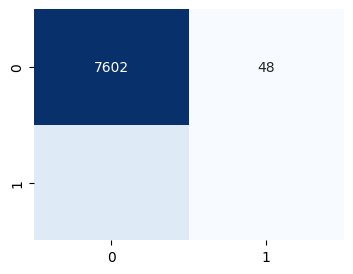

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

In [349]:
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_test, y_pred, average=None)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

Confusion Matrix:
[[7602   48]
 [1004   69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94      7650
           1       0.59      0.06      0.12      1073

    accuracy                           0.88      8723
   macro avg       0.74      0.53      0.53      8723
weighted avg       0.85      0.88      0.83      8723

F1 Scores (Per Class):
Class 0: 0.9352854330708662
Class 1: 0.11596638655462185
Weighted F1 Score: 0.8345025215826247


In [306]:
##not good for yes instances, NEXT DO UNDERSAMPLING AND SEE

## Kernelized SVC: Gaussian Radial Basis

In [23]:
start_time = time.time()

# Specify the parameter grid for gamma and C
param_grid = {'C': [0.1, 1, 10],
              'gamma': ['auto', 'scale']}

kernel = "sigmoid"
model = svm.SVC(kernel='sigmoid')

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Print the final chosen parameters of the model hyperparametrization
print("Final Parameters:")
print(grid_search.best_params_)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

model = best_model 

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['auto', 'scale']},
             scoring='accuracy')

Final Parameters:
{'C': 0.1, 'gamma': 'auto'}


168.62915706634521

In [24]:
scale = str(1 / (len(X_train) * X_train.var()))
print("scale gamma is: " + scale)
auto = str(1 / (len(X_train)))
print(" auto gamma is: " + auto)
print("auto is smaller gamma, each point in the training set has a far-reaching effect, leading to a more globalized decision boundary ")

scale gamma is: 0.0002079094623763666
 auto gamma is: 2.8663150653519834e-05
auto is smaller gamma, each point in the training set has a far-reaching effect, leading to a more globalized decision boundary 


In [279]:
'''import time
start_time = time.time()


kernel = "rbf"
sigma = "auto"
model = svm.SVC(kernel=kernel, gamma=sigma).fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time'''

'import time\nstart_time = time.time()\n\n\nkernel = "rbf"\nsigma = "auto"\nmodel = svm.SVC(kernel=kernel, gamma=sigma).fit(X_train, y_train)\n\nend_time = time.time()\nelapsed_time = end_time - start_time\nelapsed_time'

Model Accuracy: 0.88


<Figure size 400x300 with 0 Axes>

<Axes: >

Confusion Matrix:
[[7650    0]
 [1073    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      7650
           1       0.00      0.00      0.00      1073

    accuracy                           0.88      8723
   macro avg       0.44      0.50      0.47      8723
weighted avg       0.77      0.88      0.82      8723

F1 Scores (Per Class):
Class 0: 0.9344652782019177
Class 1: 0.0
Weighted F1 Score: 0.8195184429949182


C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

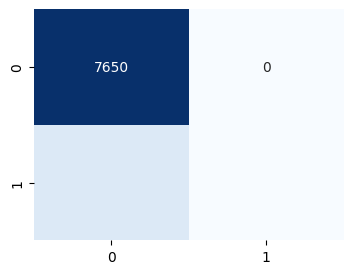

In [25]:
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_test, y_pred, average=None)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

As we can see, neither the Linear or Kernelized SVC achieve a better `accuracy` than a dummy model always predicting "no", given we have 87% of "no", and only improves the overall `f1-score` by getting a small amount of "yes" right and maintaining 88% accuracy. Nonetheless, a 6% of recall on the "yes" is still very poor.

We decided to try undersampling the amount of "no" instances in our training set and retry our SVM trainings.

# Undersampling modeling

In [26]:

def undersample (X,y):
    majority_indices_train = y[y == 0].index
    minority_indices_train = y[y == 1].index

    undersampled_majority_indices_train = resample(majority_indices_train,
                                             replace=False,
                                             n_samples=sum(y == 1),
                                             random_state=42)

    # Concatenate undersampled majority indices with minority indices
    undersampled_indices_train = pd.Index(undersampled_majority_indices_train).union(minority_indices_train)

    # Use the undersampled indices to create undersampled datasets
    X_undersampled = X.loc[undersampled_indices_train]
    y_undersampled = y.loc[undersampled_indices_train]
    
    print(X_undersampled.shape, '\n',y_undersampled.value_counts())
    return X_undersampled, y_undersampled


In [351]:
#X_train = pd.DataFrame(X_train)
#X_test = pd.DataFrame(X_test)
#y_train = pd.DataFrame(y_train)
#y_test = pd.DataFrame(y_test)




In [27]:
X_undersampled_train, y_undersampled_train = undersample(X_train_before_minmax, y_train)
X_undersampled_test, y_undersampled_test = undersample(X_test_before_minmax, y_test)

(8276, 28) 
 y
0    4138
1    4138
Name: count, dtype: int64
(2146, 28) 
 y
0    1073
1    1073
Name: count, dtype: int64


In [28]:
X_undersampled_train, y_undersampled_train, scaler = minmaxscaling(X_undersampled_train,y_undersampled_train)
X_undersampled_test, y_undersampled_test, _ = minmaxscaling(X_undersampled_test,y_undersampled_test,scaler)

## Linear SVC


In [30]:
import time
start_time = time.time()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Primal, n_features < n_samples
model = svm.LinearSVC(dual=False)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_undersampled_train, y_undersampled_train)

# Print the final chosen parameters of the model hyperparametrization
print("Final Parameters:")
print(grid_search.best_params_)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

model = best_model 

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

GridSearchCV(cv=5, estimator=LinearSVC(dual=False),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

Final Parameters:
{'C': 0.01}


0.39372730255126953

### Evaluation on undersampled test set (for predictability analysis)

Model Accuracy: 0.68


<Figure size 400x300 with 0 Axes>

<Axes: >

Confusion Matrix:
[[730 343]
 [334 739]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      1073
           1       0.68      0.69      0.69      1073

    accuracy                           0.68      2146
   macro avg       0.68      0.68      0.68      2146
weighted avg       0.68      0.68      0.68      2146

F1 Scores (Per Class):
Class 0: 0.6832007487131493
Class 1: 0.6858468677494199
Weighted F1 Score: 0.6845238082312846


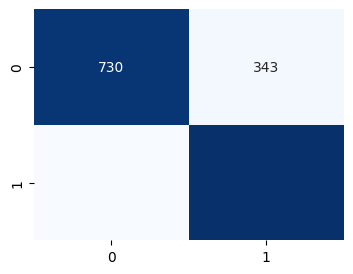

In [355]:
y_pred = model.predict(X_undersampled_test)
print(f"Model Accuracy: {accuracy_score(y_undersampled_test, y_pred):.2f}")

conf_matrix = confusion_matrix(y_undersampled_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_undersampled_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_undersampled_test, y_pred, average=None)
weighted_f1 = f1_score(y_undersampled_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

### Evaluation on original test set (real life)

Model Accuracy: 0.69


<Figure size 400x300 with 0 Axes>

<Axes: >

Confusion Matrix:
[[5274 2376]
 [ 336  737]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80      7650
           1       0.24      0.69      0.35      1073

    accuracy                           0.69      8723
   macro avg       0.59      0.69      0.57      8723
weighted avg       0.85      0.69      0.74      8723

F1 Scores (Per Class):
Class 0: 0.7954751131221719
Class 1: 0.3521261347348304
Weighted F1 Score: 0.7409395801851528


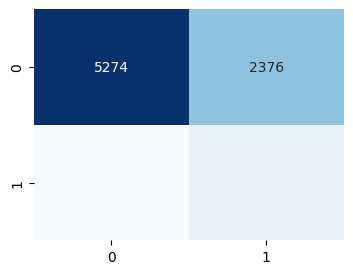

In [31]:
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_test, y_pred, average=None)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

## GRBF 

In [37]:
start_time = time.time()

# Specify the parameter grid for gamma and C
param_grid = {'C': [0.1,1,10],
              'gamma': ['auto', 'scale'],
             }

kernel = "rbf"
model = svm.SVC(kernel='rbf')


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_undersampled_train, y_undersampled_train)

# Print the final chosen parameters of the model hyperparametrization
print("Final Parameters:")
print(grid_search.best_params_)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

model = best_model 

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['auto', 'scale']},
             scoring='accuracy')

Final Parameters:
{'C': 10, 'gamma': 'scale'}


39.09946060180664

In [33]:
scale = str(1 / (len(X_undersampled_train) * X_undersampled_train.var()))
print("scale gamma is: " + scale)
auto = str(1 / (len(X_undersampled_train)))
print(" auto gamma is: " + auto)
print("auto is smaller gamma, each point in the training set has a far-reaching effect, leading to a more globalized decision boundary ")

scale gamma is: 0.000885544233841564
 auto gamma is: 0.0001208313194780087
auto is smaller gamma, each point in the training set has a far-reaching effect, leading to a more globalized decision boundary 


In [377]:
'''import time
start_time = time.time()


kernel = "rbf"
sigma = "auto"
model = svm.SVC(kernel=kernel, gamma=sigma).fit(X_undersampled_train, y_undersampled_train)

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time'''

'import time\nstart_time = time.time()\n\n\nkernel = "rbf"\nsigma = "auto"\nmodel = svm.SVC(kernel=kernel, gamma=sigma).fit(X_undersampled_train, y_undersampled_train)\n\nend_time = time.time()\nelapsed_time = end_time - start_time\nelapsed_time'

### Evaluation on undersampled test set (for predictability analysis)

Model Accuracy: 0.64


<Figure size 400x300 with 0 Axes>

<Axes: >

Confusion Matrix:
[[477 596]
 [185 888]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.44      0.55      1073
           1       0.60      0.83      0.69      1073

    accuracy                           0.64      2146
   macro avg       0.66      0.64      0.62      2146
weighted avg       0.66      0.64      0.62      2146

F1 Scores (Per Class):
Class 0: 0.5498559077809798
Class 1: 0.6945639421196715
Weighted F1 Score: 0.6222099249503257


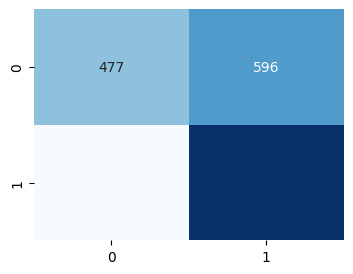

In [378]:
y_pred = model.predict(X_undersampled_test)
print(f"Model Accuracy: {accuracy_score(y_undersampled_test, y_pred):.2f}")

conf_matrix = confusion_matrix(y_undersampled_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_undersampled_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_undersampled_test, y_pred, average=None)
weighted_f1 = f1_score(y_undersampled_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

### Evaluation on original test set (real life)

Model Accuracy: 0.78


<Figure size 400x300 with 0 Axes>

<Axes: >

Confusion Matrix:
[[6183 1467]
 [ 424  649]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      7650
           1       0.31      0.60      0.41      1073

    accuracy                           0.78      8723
   macro avg       0.62      0.71      0.64      8723
weighted avg       0.86      0.78      0.81      8723

F1 Scores (Per Class):
Class 0: 0.8673634004348741
Class 1: 0.4070241455001568
Weighted F1 Score: 0.8107379251918441


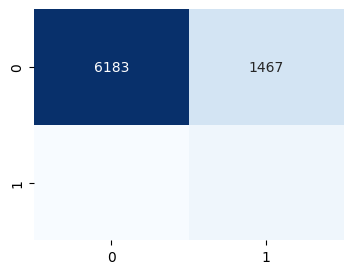

In [38]:
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_test, y_pred, average=None)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

In [ ]:
print("Result: ON 24% OF DATA PREDICTED AS YES, WE GET 60% OF RECALL OF YES")

# Recall of 'yes' based undersampling

Which means giving more weight to class "yes" and/or having recall as the scoring hyperparametrization criteria

## GRBF (scoring accuracy, x2 yes)

In [43]:
start_time = time.time()

# Specify the parameter grid for gamma and C
param_grid = {'C': [0.1, 1, 10],
              'gamma': ['auto', 'scale'],
              'class_weight': [{0: 1, 1: 2}]}

kernel = "rbf"
model = svm.SVC(kernel='rbf')


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_undersampled_train, y_undersampled_train)

# Print the final chosen parameters of the model hyperparametrization
print("Final Parameters:")
print(grid_search.best_params_)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

model = best_model 

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': [{0: 1, 1: 2}],
                         'gamma': ['auto', 'scale']},
             scoring='accuracy')

Final Parameters:
{'C': 10, 'class_weight': {0: 1, 1: 2}, 'gamma': 'scale'}


43.024659156799316

Model Accuracy: 0.49
Confusion Matrix:
[[3421 4229]
 [ 184  889]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.45      0.61      7650
           1       0.17      0.83      0.29      1073

    accuracy                           0.49      8723
   macro avg       0.56      0.64      0.45      8723
weighted avg       0.85      0.49      0.57      8723

F1 Scores (Per Class):
Class 0: 0.6079075966237227
Class 1: 0.2871910838313681
Weighted F1 Score: 0.5684568551097714


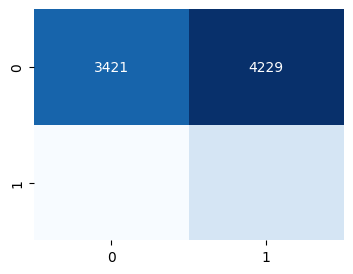

In [44]:
evaluate_model(model, X_test, y_test) #on original test set

In [413]:
print("Result: ON 58% OF DATA PREDICTED AS YES, WE GET 83% OF RECALL OF YES")

Result: ON 58% OF DATA PREDICTED AS YES, WE GET 83% OF RECALL OF YES


## GRBF (scoring recall, x2 yes)

In [41]:
start_time = time.time()

# Specify the parameter grid for gamma and C
param_grid = {'C': [0.1, 1, 10],
              'gamma': ['auto', 'scale'],
              'class_weight': [{0: 1, 1: 2}]}

kernel = "sigmoid"
model = svm.SVC(kernel='sigmoid')


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')

grid_search.fit(X_undersampled_train, y_undersampled_train)

# Print the final chosen parameters of the model hyperparametrization
print("Final Parameters:")
print(grid_search.best_params_)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

model = best_model 

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': [0.1, 1, 10], 'class_weight': [{0: 1, 1: 2}],
                         'gamma': ['auto', 'scale']},
             scoring='recall')

Final Parameters:
{'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'gamma': 'auto'}


32.66534948348999

Model Accuracy: 0.38
Confusion Matrix:
[[2342 5308]
 [ 110  963]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.31      0.46      7650
           1       0.15      0.90      0.26      1073

    accuracy                           0.38      8723
   macro avg       0.55      0.60      0.36      8723
weighted avg       0.86      0.38      0.44      8723

F1 Scores (Per Class):
Class 0: 0.4636705602850921
Class 1: 0.2622549019607843
Weighted F1 Score: 0.43889479490827427


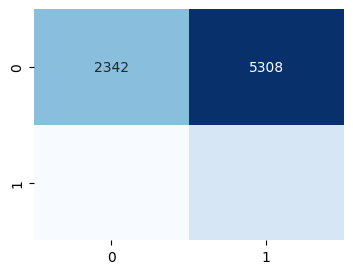

In [42]:
evaluate_model(model, X_test, y_test) # on original test set

In [414]:
print("Result: ON 72% OF DATA PREDICTED AS YES, WE GET 90% OF RECALL OF YES")

Result: ON 72% OF DATA PREDICTED AS YES, WE GET 90% OF RECALL OF YES


array([[0.44      , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.38666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.18666667, 0.5       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.69333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.61333333, 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

## Cross-Validation, Model-Comparison & Hyper-parameter Tuning (old)

In [423]:
# Accuracy focused


# Define the models and their hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(solver='liblinear'), {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    'SVM_linear': (svm.LinearSVC(dual=False), {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    # 'SVM_poly': (SVC(kernel='poly'), {'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    # 'SVM_rbf': (SVC(kernel='rbf'), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    # 'SVM_sigmoid': (SVC(kernel='sigmoid'), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    #'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01, 0.001],}),
    #'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    #'Naive Bayes': (GaussianNB(), {}),
}

# Define a custom scoring function to calculate precision, recall, F1-score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1_score': make_scorer(f1_score, pos_label=1)
}

# Perform cross-validation and hyperparameter tuning for each model
results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='accuracy')
    grid_search.fit(X_undersampled_train, y_undersampled_train)
    
    # Get the mean cross-validated scores for each metric
    cv_results = grid_search.cv_results_
    mean_scores = {
        'Accuracy': cv_results['mean_test_accuracy'][grid_search.best_index_],
        'Precision': cv_results['mean_test_precision'][grid_search.best_index_],
        'Recall': cv_results['mean_test_recall'][grid_search.best_index_],
        'F1-score': cv_results['mean_test_f1_score'][grid_search.best_index_]
    }
    
    results[model_name] = {
        'Best Hyperparameters': grid_search.best_params_,
        **mean_scores,
        'Validation Errors': cv_results['std_test_accuracy'][grid_search.best_index_]
    }

# Create a dataframe to store the results
df_results = pd.DataFrame(results).transpose()
df_results.index.name = 'Model'


C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced', {0: 1, 1: 2}],
                         'penalty': ['l1', 'l2']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)})

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', {0: 1, 1: 2}],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)})

GridSearchCV(cv=5, estimator=LinearSVC(dual=False),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', {0: 1, 1: 2}]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)})

In [424]:
df_results

,Best Hyperparameters,Accuracy,Precision,Recall,F1-score,Validation Errors
Model,,,,,,
Logistic Regression,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",0.682818,0.685159,0.676413,0.680716,0.010271
Random Forest,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.716408,0.747565,0.653696,0.697391,0.006221
SVM_linear,"{'C': 0.01, 'class_weight': 'balanced'}",0.681126,0.682316,0.677864,0.680051,0.010403


In [425]:
# Recall focused

# Define the models and their hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(solver='liblinear'), {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    'SVM_linear': (svm.LinearSVC(dual=False), {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    'SVM_poly': (SVC(kernel='poly'), {'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    'SVM_rbf': (SVC(kernel='rbf'), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    # 'SVM_sigmoid': (SVC(kernel='sigmoid'), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'class_weight': ['balanced', {0: 1, 1: 2}]}),
    # 'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01, 0.001]}),
    # 'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    # 'Naive Bayes': (GaussianNB(), {}),
}

# Define a custom scoring function to calculate precision, recall, F1-score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1_score': make_scorer(f1_score, pos_label=1)
}

# Perform cross-validation and hyperparameter tuning for each model
results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='recall')
    grid_search.fit(X_undersampled_train, y_undersampled_train)
    
    # Get the mean cross-validated scores for each metric
    cv_results = grid_search.cv_results_
    mean_scores = {
        'Accuracy': cv_results['mean_test_accuracy'][grid_search.best_index_],
        'Precision': cv_results['mean_test_precision'][grid_search.best_index_],
        'Recall': cv_results['mean_test_recall'][grid_search.best_index_],
        'F1-score': cv_results['mean_test_f1_score'][grid_search.best_index_]
    }
    
    results[model_name] = {
        'Best Hyperparameters': grid_search.best_params_,
        **mean_scores,
        'Validation Errors': cv_results['std_test_accuracy'][grid_search.best_index_]
    }

# Create a dataframe to store the results
df_results = pd.DataFrame(results).transpose()
df_results.index.name = 'Model'

C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauco\AppData\Roaming\Python\Python311\site-packages

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced', {0: 1, 1: 2}],
                         'penalty': ['l1', 'l2']},
             refit='recall',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)})

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', {0: 1, 1: 2}],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='recall',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)})

GridSearchCV(cv=5, estimator=LinearSVC(dual=False),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', {0: 1, 1: 2}]},
             refit='recall',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)})

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': [0.1, 1, 10],
                         'class_weight': ['balanced', {0: 1, 1: 2}],
                         'degree': [2, 3, 4]},
             refit='recall',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)})

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10],
                         'class_weight': ['balanced', {0: 1, 1: 2}],
                         'gamma': ['scale', 'auto']},
             refit='recall',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=1),
                      'precision': make_scorer(precision_score, pos_label=1),
                      'recall': make_scorer(recall_score, pos_label=1)})

In [427]:
df_results

,Best Hyperparameters,Accuracy,Precision,Recall,F1-score,Validation Errors
Model,,,,,,
Logistic Regression,"{'C': 0.001, 'class_weight': {0: 1, 1: 2}, 'pe...",0.555582,0.530773,0.959643,0.683484,0.005983
Random Forest,"{'class_weight': {0: 1, 1: 2}, 'max_depth': 5,...",0.609474,0.568394,0.909619,0.699616,0.006655
SVM_linear,"{'C': 0.001, 'class_weight': {0: 1, 1: 2}}",0.590745,0.554641,0.921217,0.692381,0.004234
SVM_poly,"{'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'degr...",0.607903,0.567365,0.908651,0.698548,0.006486
SVM_rbf,"{'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'gamm...",0.607903,0.567584,0.905993,0.697927,0.006828
